#### Setup

In [3]:
import mne              # toolbox for analyzing and visualizing EEG data
import pandas as pd     # data analysis and manipulation
import numpy as np      # numerical computing (manipulating and performing operations on arrays of data)
import os               # using operating system dependent functionality (folders)
import glob             # functions for matching and finding pathnames using patterns
import copy             # Can Copy and Deepcopy files so original file is untouched
import sys              # system-specific information and resources
from IPython.display import clear_output

main_path = os.path.dirname(os.getcwd())
eegyolk_path = os.path.join(main_path, 'eegyolk')
# eegyolk_path = 'C:/ePodium/eegyolk'
sys.path.insert(0, eegyolk_path)
from eegyolk import initialization_functions as ifun
from eegyolk import epod_helper as epod
from eegyolk import display_helper as disp

#### Loading data (EEG files + metadata)

In [2]:
# Change these paths to where the data is stored on your computer.   
# folder_dataset = os.path.join("D:", os.sep, "EEG Data", "ePodium Dataset", "Dataset")
# folder_metadata = os.path.join("D:", os.sep, "EEG Data", "ePodium Dataset", "Metadata")
# folder_event_markers = os.path.join("D:", os.sep, "EEG Data", "ePodium Dataset", "event_markers")
folder_dataset = os.path.join("C:", os.sep, "Floris", "ePodium Dataset", "Dataset")
folder_metadata = os.path.join("C:", os.sep, "Floris", "ePodium Dataset", "Metadata")
folder_event_markers = os.path.join("C:", os.sep, "Floris", "ePodium Dataset", "event_markers")

In [4]:
filenames_metadata = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]  
children, cdi, parents, codes = ifun.load_metadata(folder_metadata, filenames_metadata)
eeg_dataset, eeg_filenames, eeg_filepaths = ifun.load_dataset(folder_dataset)

print("\n", eeg_dataset[0].info)

124 EEG files loaded

 <Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 40 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2021-03-01 09:29:57 UTC
 nchan: 41
 projs: []
 sfreq: 2048.0 Hz
>


#### Load event markers
Events are stored and loaded externally from a text file, since loading events from raw EEG file takes much longer. Set save_events_to_txt_file to true if the event markers are not yet on your disk. This will take a while. The text files are only ~4MB.

Information from each event can be printed given the participant and event index.

The events for four conditions are plotted from a single experiment. The events are combined so the different pronounciations or 'tokens' are not individually marked. This reduces the unique events from 78 to 12.
Condition 1 GiepMT: standard "giep" - deviant "gip": multiple tokens (pronounciations)
Condition 2 GiepST: standard "giep" - deviant "gip": single token (pronounciation)
Condition 3 GopMT: standard "gop" - deviant "goep": multiple tokens (pronounciations)
Condition 4 GopST: standard "gop" - deviant "goep": single tokens (pronounciation)

124 Event Marker files loaded
Participant 5 heard event ID: 17 after 388.5 seconds as the 500th event


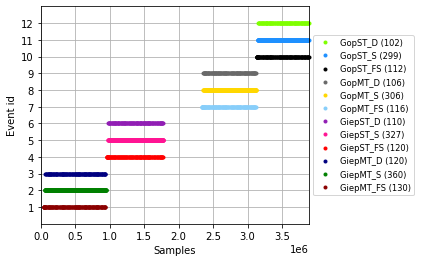

In [3]:
save_events_to_txt_file = False
if(save_events_to_txt_file):
    ifun.save_event_markers(folder_event_markers, eeg_dataset, eeg_filenames)
    
event_markers = ifun.load_event_markers(folder_event_markers, eeg_filenames)

ifun.print_event_info(event_markers, participant_index = 5, event_index = 500)

event_markers_12 = epod.group_event_markers(event_markers)
%matplotlib inline 
fig = mne.viz.plot_events(event_markers_12[4], event_id = epod.event_dictionary, color = disp.color_dictionary)

Visualization of the EEG signal including the markers:

Opening raw-browser...


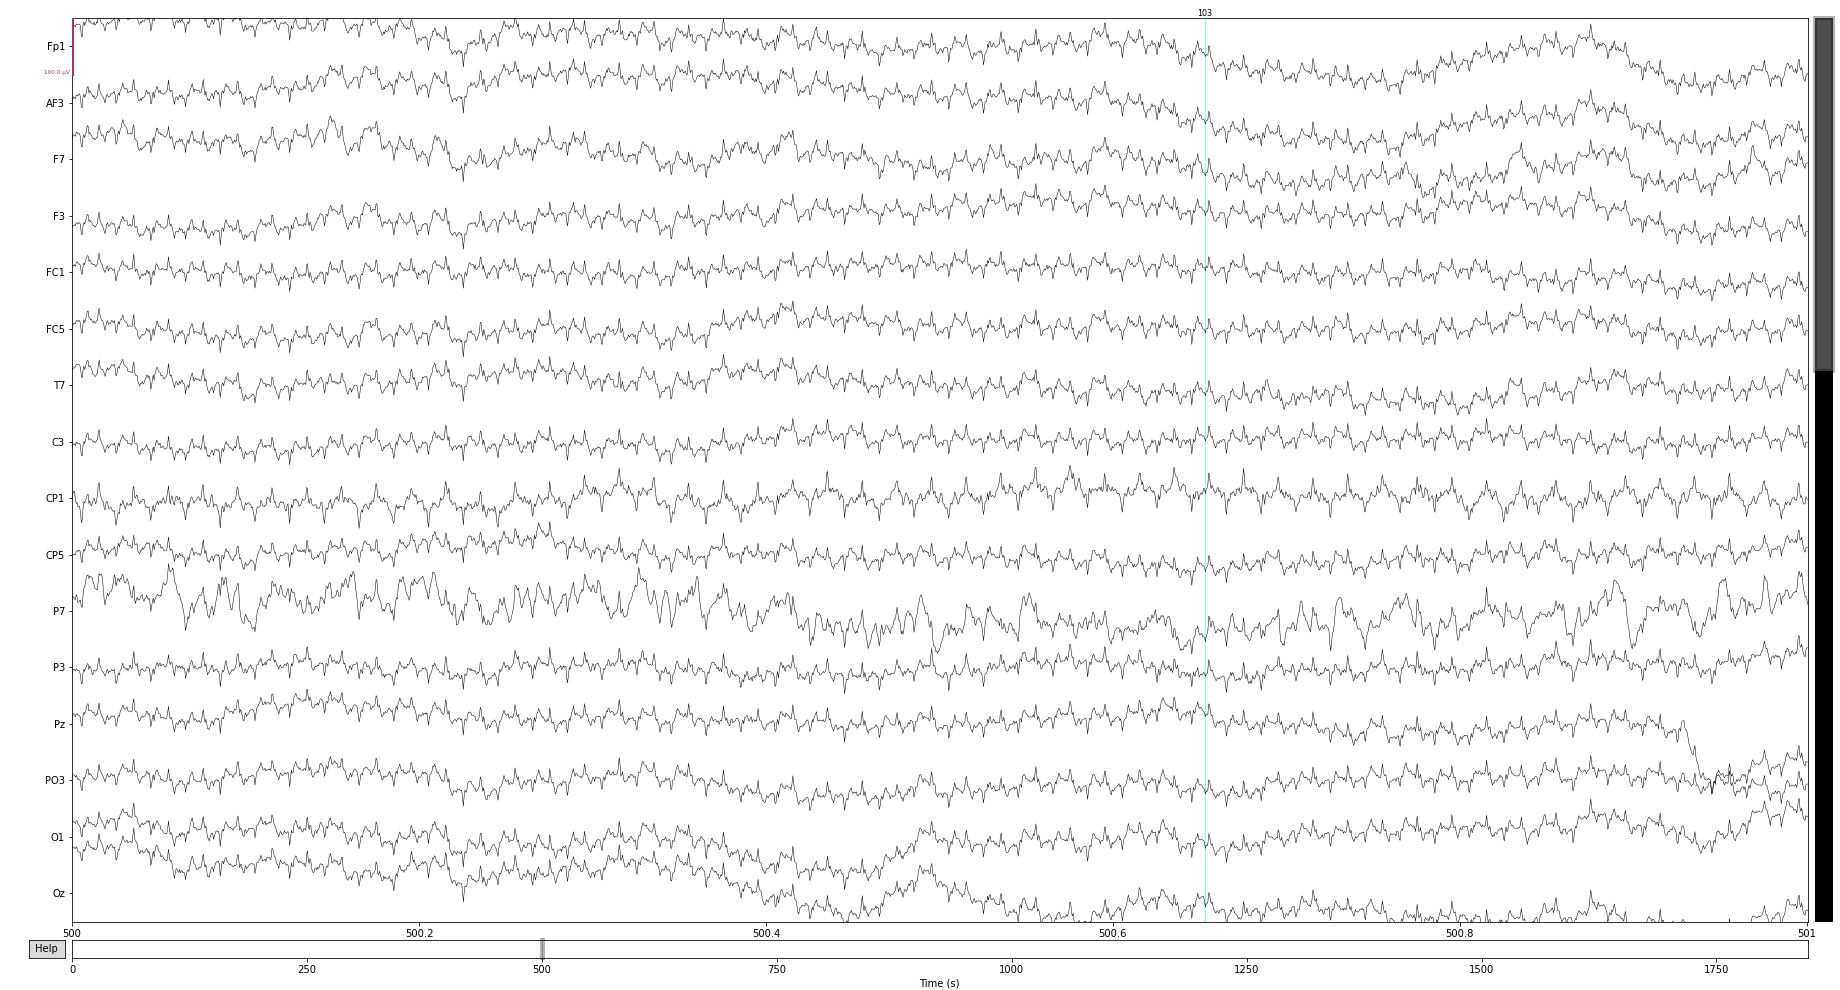

In [5]:
participant_index = 3
# %matplotlib qt / widget for interactive (remove 'fig = ' if no figure shows)
%matplotlib widget 
fig = mne.viz.plot_raw(eeg_dataset[participant_index], event_markers[participant_index], n_channels=16, scalings = 50e-6  ,duration = 1, start = 500)